In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import sqlite3
import os
import re
import plotly
import plotly.graph_objs as go
import cufflinks as cf
%matplotlib inline

In [2]:
cf.go_offline()

In [3]:
data_dir = './smart-money-concepts_old/updates/Data/'
os.listdir(data_dir)

['NQ_4H.csv',
 'NQ_1H.csv',
 'NQ_1D.csv',
 'NQ_1min.csv',
 'ES_5min.csv',
 'NQ_5min.csv',
 'EURUSD_15M.csv',
 'ES_1min.csv',
 'ES 12-24.Last.txt',
 'ES 12-24.Last_min.txt',
 'NQ_15min.csv',
 'NQ 12-24.Last.txt']

In [4]:
regex = r'\w*.csv'
csv_filenames = [i for i in os.listdir(data_dir) if re.match(regex, i)]
csv_filenames
#for i in os.listdir(data_dir):
#    if (i)

['NQ_4H.csv',
 'NQ_1H.csv',
 'NQ_1D.csv',
 'NQ_1min.csv',
 'ES_5min.csv',
 'NQ_5min.csv',
 'EURUSD_15M.csv',
 'ES_1min.csv',
 'NQ_15min.csv']

In [5]:
data_files = [pd.read_csv(data_dir + i) for i in csv_filenames]

In [6]:
data_files[0]

,datetime,open,high,low,close,volume
0,2024-09-12 04:00:00,19538.25,19575.25,19504.25,19516.25,1925
1,2024-09-12 08:00:00,19514.50,19567.25,19494.50,19533.75,1534
2,2024-09-12 12:00:00,19535.25,19623.50,19418.25,19501.25,5326
3,2024-09-12 16:00:00,19497.50,19716.75,19497.50,19686.00,5602
4,2024-09-12 20:00:00,19685.75,19706.00,19636.50,19687.25,2248
...,...,...,...,...,...,...
261,2024-11-07 20:00:00,21233.00,21253.00,21202.50,21227.25,84030
262,2024-11-08 00:00:00,21227.00,21245.00,21215.50,21226.75,11473
263,2024-11-08 04:00:00,21226.25,21263.25,21221.50,21240.00,12166
264,2024-11-08 08:00:00,21239.75,21250.50,21121.75,21162.00,34074


<strong>NOTE:</strong> to avoid duplicates, use max timestamp as marker and then append the values after that.

<Axes: xlabel='datetime'>

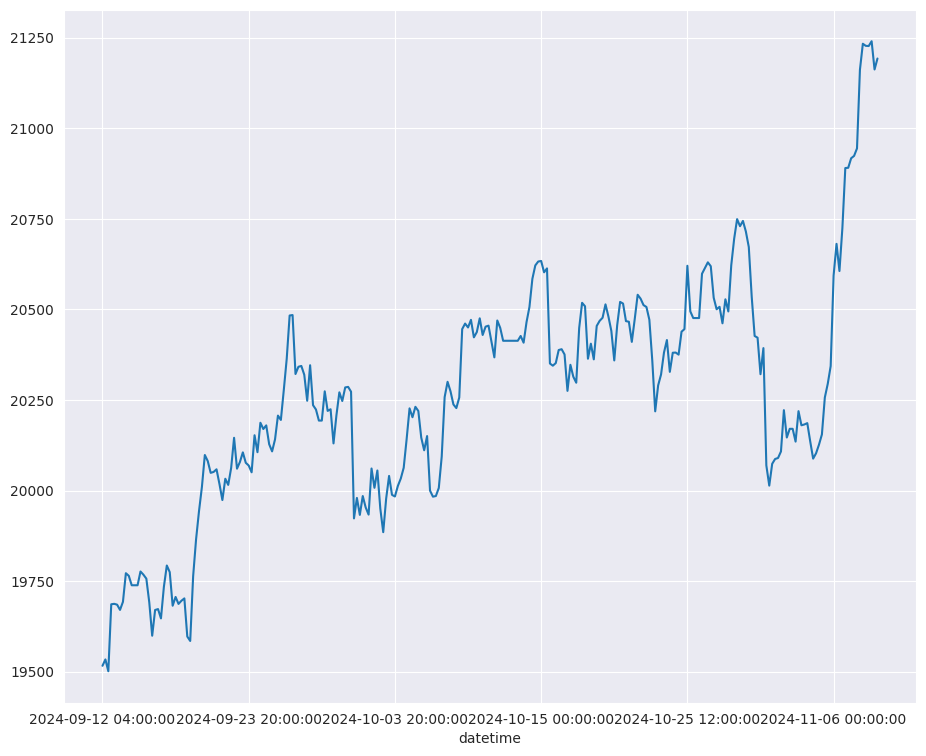

In [7]:
sns.set_style('darkgrid')
plt.figure(figsize=(11,9))
data_files[0].set_index('datetime').close.astype(float).plot()

In [8]:
#df = pd.read_csv('\\smart-money-concepts_old\\updates\\Data\\')

conn = sqlite3.connect('market_data.db')
cursor = conn.cursor()

In [9]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS market_data (
    ticker TEXT,
    datetime TEXT,
    open REAL,
    high REAL,
    low REAL,
    close REAL,
    volume INTEGER
)
''')
conn.commit()

#cursor.execute('ALTER TABLE market_data RENAME COLUMN datetime TO timestamp;')
#conn.commit()

In [10]:
def fetch_data(ticker):
    """
    Function stub that fetches data
    TODO: add functionality to collect data using API and provided ticker value
    
    :ticker: ticker to fetch data for. eg: "IBM" 
    :return: market data for given ticker value
    """
    pass;

def fetch_data_local():
    """
    Placeholder function that fetches local data for now
    
    :return: dictionary with filename as key and dataframe as value
    """
    data_dir = './smart-money-concepts_old/updates/Data/'
    
    regex = r'\w*.csv'
    csv_filenames = [i for i in os.listdir(data_dir) if re.match(regex, i)]
    csv_filenames
    data_files = [pd.read_csv(data_dir + i) for i in csv_filenames]
    data = dict(zip(csv_filenames, data_files))
    for k,v in data:
        data[v]['ticker'] = k
    #for i in os.listdir(data_dir):
    #    if (i)
    return data


def fetch_data_local(ticker):
    """
    Placeholder function that fetches local data for now
    
    :ticker: index value for fetching local files. 
    :return: dictionary with filename as key and dataframe as value
    """
    data_dir = './smart-money-concepts_old/updates/Data/'
    data_files = pd.read_csv(data_dir + ticker)
    #data = dict([ticker], data_files)
    #for k,v in data:
    #    data[v]['ticker'] = k
    #for i in os.listdir(data_dir):
    #    if (i)
    data_files['ticker'] = ticker
    return data_files
    

In [11]:
## for getting lastest timestamp using sql
## NOTE: make sure timestamp values are typecasted properly in db!

def get_latest_timestamp(ticker):
    """
        gets the latest timestamp from the given data
        NOTE: If using local files, the 'ticker' value will be the filename
        :ticker: ticker to be used to access data point; for example it will be 'IBM' for IBM's ticker. This is entirely reliant on an external API to fetch the data
        :return: returns most recent (largest) timestamp value from table or None
    """
    query = """SELECT MAX(timestamp) FROM market_data WHERE ticker = ?"""
    cursor.execute(query, (ticker, ))
    result = cursor.fetchone()[0]
    return result

In [12]:
print (get_latest_timestamp("NQ_4H.csv"))

2024-11-08 12:00:00


In [13]:
## for storing data to db

def store_data_to_db(data, latest_timestamp = None):
    """
        stores the data (usually recently fetched) into our sql database
        
        :data:       the fetched data
        :latest:     the most recent timestamp from data
        :timestamp:  the most recent timestamp from data already stored in database
    """
    
    
    if data is not None:
        data = data.rename(columns={'datetime': 'timestamp'})
        if latest_timestamp:
            data = data[data['timestamp'] > latest_timestamp]
        
        if not data.empty:
            data.to_sql('market_data', conn, if_exists='append', index=False)
            print(f"Data for {data['ticker'].iloc[0]} stored successfully.")
        else:
            print(f"No New data to store.")
    else:
        print(f"No data to store.")

In [14]:
def main():
    tickers = ["NQ_4H.csv"] ## insert tickers you want market data for 
    for ticker in tickers:
        #latest_timestamp = get_latest_timestamp(ticker)
        data = fetch_data_local(ticker)
        #store_data_to_db(data, latest_timestamp)
        store_data_to_db(data)
    
    if __name__ == "__main__":
        main()

In [51]:
#main()

Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


KeyboardInterrupt: 

In [15]:
def query_data(ticker, start_time, end_time):
    """
    Custom query function to get ticker data for specified timeframe
    
    :ticker:      ticker value to get data for
    :start_time:  time value for start of filter
    :end_time:    time value for end of filter
    :return:      ticker data filtered by given time values 
    """
    
    query = f"""
    SELECT * FROM market_data
    WHERE ticker = '{ticker}'
    AND timestamp BETWEEN '{start_time}' AND '{end_time}'
    """
    df = pd.read_sql(query, conn)
    return df

In [16]:
df = query_data('NQ_4H.csv', '2024-09-12 12:00:00', '2024-11-07 20:00:00')

In [17]:
df

,ticker,timestamp,open,high,low,close,volume
0,NQ_4H.csv,2024-09-12 12:00:00,19535.25,19623.50,19418.25,19501.25,5326
1,NQ_4H.csv,2024-09-12 16:00:00,19497.50,19716.75,19497.50,19686.00,5602
2,NQ_4H.csv,2024-09-12 20:00:00,19685.75,19706.00,19636.50,19687.25,2248
3,NQ_4H.csv,2024-09-13 00:00:00,19687.75,19706.75,19654.50,19685.00,3342
4,NQ_4H.csv,2024-09-13 04:00:00,19685.75,19722.00,19665.00,19670.50,4307
...,...,...,...,...,...,...,...
409235,NQ_4H.csv,2024-11-07 04:00:00,20917.25,20966.25,20907.75,20923.50,15300
409236,NQ_4H.csv,2024-11-07 08:00:00,20923.25,20961.00,20915.00,20944.25,20273
409237,NQ_4H.csv,2024-11-07 12:00:00,20943.25,21167.25,20941.00,21161.00,162566
409238,NQ_4H.csv,2024-11-07 16:00:00,21160.75,21233.00,21124.25,21233.00,155805


In [18]:
fetch_data_local("NQ_4H.csv")

,datetime,open,high,low,close,volume,ticker
0,2024-09-12 04:00:00,19538.25,19575.25,19504.25,19516.25,1925,NQ_4H.csv
1,2024-09-12 08:00:00,19514.50,19567.25,19494.50,19533.75,1534,NQ_4H.csv
2,2024-09-12 12:00:00,19535.25,19623.50,19418.25,19501.25,5326,NQ_4H.csv
3,2024-09-12 16:00:00,19497.50,19716.75,19497.50,19686.00,5602,NQ_4H.csv
4,2024-09-12 20:00:00,19685.75,19706.00,19636.50,19687.25,2248,NQ_4H.csv
...,...,...,...,...,...,...,...
261,2024-11-07 20:00:00,21233.00,21253.00,21202.50,21227.25,84030,NQ_4H.csv
262,2024-11-08 00:00:00,21227.00,21245.00,21215.50,21226.75,11473,NQ_4H.csv
263,2024-11-08 04:00:00,21226.25,21263.25,21221.50,21240.00,12166,NQ_4H.csv
264,2024-11-08 08:00:00,21239.75,21250.50,21121.75,21162.00,34074,NQ_4H.csv


In [28]:
data_files = {csv_filenames, [pd.read_csv(data_dir + i) for i in csv_filenames]}
data_files

TypeError: unhashable type: 'list'

In [27]:
data.columns

Index(['close'], dtype='object')

In [29]:
print(list(data_files))

[                datetime      open      high       low     close  volume
0    2024-09-12 04:00:00  19538.25  19575.25  19504.25  19516.25    1925
1    2024-09-12 08:00:00  19514.50  19567.25  19494.50  19533.75    1534
2    2024-09-12 12:00:00  19535.25  19623.50  19418.25  19501.25    5326
3    2024-09-12 16:00:00  19497.50  19716.75  19497.50  19686.00    5602
4    2024-09-12 20:00:00  19685.75  19706.00  19636.50  19687.25    2248
..                   ...       ...       ...       ...       ...     ...
261  2024-11-07 20:00:00  21233.00  21253.00  21202.50  21227.25   84030
262  2024-11-08 00:00:00  21227.00  21245.00  21215.50  21226.75   11473
263  2024-11-08 04:00:00  21226.25  21263.25  21221.50  21240.00   12166
264  2024-11-08 08:00:00  21239.75  21250.50  21121.75  21162.00   34074
265  2024-11-08 12:00:00  21162.25  21232.25  21156.25  21192.25   58551

[266 rows x 6 columns],                 datetime      open      high       low     close  volume
0    2024-09-12 04:00:00 

In [30]:
dict(zip(csv_filenames, data_files))

{'NQ_4H.csv':                 datetime      open      high       low     close  volume
 0    2024-09-12 04:00:00  19538.25  19575.25  19504.25  19516.25    1925
 1    2024-09-12 08:00:00  19514.50  19567.25  19494.50  19533.75    1534
 2    2024-09-12 12:00:00  19535.25  19623.50  19418.25  19501.25    5326
 3    2024-09-12 16:00:00  19497.50  19716.75  19497.50  19686.00    5602
 4    2024-09-12 20:00:00  19685.75  19706.00  19636.50  19687.25    2248
 ..                   ...       ...       ...       ...       ...     ...
 261  2024-11-07 20:00:00  21233.00  21253.00  21202.50  21227.25   84030
 262  2024-11-08 00:00:00  21227.00  21245.00  21215.50  21226.75   11473
 263  2024-11-08 04:00:00  21226.25  21263.25  21221.50  21240.00   12166
 264  2024-11-08 08:00:00  21239.75  21250.50  21121.75  21162.00   34074
 265  2024-11-08 12:00:00  21162.25  21232.25  21156.25  21192.25   58551
 
 [266 rows x 6 columns],
 'NQ_1H.csv':                 datetime      open      high       low    

In [24]:
data = data_files[0].set_index('datetime')[['close']]
fig = go.Figure(data=[go.Scatter(x=data.index, y=data['close'])])

In [31]:
data = data_files[0]
fig = go.Figure(data = [go.Candlestick(x = data['datetime'],
                                       open= data['open'],
                                       close = data['close'],
                                       high = data['high'],
                                       low = data['low']
                                        )])

In [32]:
fig